In [1]:
import numpy as np
import matplotlib as mpl
import random, functools
from utilities.utils import *

In [2]:
class Problem():
    
    def __init__(self, init_state_in, goal_state_in=None):
        self.initial_state = init_state_in
        self.goal_state = goal_state_in
        
    def actions(self, state):
        "returns list of actions for the given state"
        raise NotImplementedError
        
    def goal_test(self, state):
        if isinstance(self.goal_state, list):
            return is_in(state,self.goal_state)
        else:
            return state == self.goal_state
        
    def path_cost(self, cost, state1, state2, action):
        "returns the cost of applying an action from state1 resulting in state2. Defaults to adding 1 to the cost"
        return cost+1
    
    def value(self, state):
        "used in optimization problems"
        raise NotImplementedError
        
    def result(self, state, action):
        "returns the new state formed by applying the action to the state, must be a member of the state's action list"
        raise NotImplementedError

In [3]:
class Node():
    
    def __init__(self, state_in, parent_in=None, action_in=None, path_cost_in=0):
        self.state, self.parent, self.action, self.path_cost = state_in, parent_in, action_in, path_cost_in
        self.depth = self.parent.depth + 1 if self.parent else 0
            
    def __repr__(self):
        return "Node {}".format(self.state)
    
    def __lt__(self, node):
        return self.state < node.state
    
    def __gt__(self, node):
        return self.state > node.state
    
    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state
    
    def __hash__(self):
        "allows for quick lookup for equal node in a Hash Table"
        return hash(self.state) #not using the tuple-design as we only care about state equality
    
    def child_node(self, problem, action):
        next_state = problem.result(self.state, action)
        new_cost = problem.path_cost(self.path_cost, self, next_state, action)
        c_node = Node(next_state, self, action, new_cost)
        return c_node

    def path(self):
        node = self, path_to_root=[]
        while node:
            path_to_root.append(node)
            node = node.parent
        return reversed(path_to_root)
    
    def expand(self, problem):
        "returns the nodes reachable in one step"
        return [self.child_node(problem, action) for action in problem.actions(self.state)]
    
    def solution(self):
        "returns action list from root->this node"
        return [node.action for node in self.path()[1:]]

In [4]:
class Simple_Problem_Agent():
    "an abstract, atomicly represented problem solving agent->Formulate, Search, Execute"
    
    def __init__(self, inital_state):
        self.action_sequence = []
        self.state = inital_state

    def __call__(self, percept):
        self.state = self.update_state(self.state, percept)
        if not self.action_sequence:
            goal = self.formulate_goal(self.state)
            problem = self.formulate_problem(self.state, goal)
            self.action_sequence = self.search(problem)
            if not self.action_sequence:
                return None
        return self.action_sequence.pop(0)

    def update_state(self, state, percept):
        raise NotImplementedError

    def formulate_goal(self, state):
        raise NotImplementedError

    def formulate_problem(self, state, goal):
        raise NotImplementedError

    def search(self, problem):
        raise NotImplementedError
        

In [5]:
class GraphProblem(Problem):
    def __init__(self, init_state, goal_state, graph_in):
        self.graph = graph_in
        super().__init__(init_state, goal_state)
    def actions(self, A):
        return list(self.graph.get(A).keys())
    
    def result(self, state, action):
        return action
    
    def path_cost(self, current_cost, A, action, B):
        return current_cost + (self.graph.get(A,B) or np.inf)
    
    def minimum_edge(self):
        min_val = np.inf
        for d in self.graph.graph_dict.values():
            local_min = min(d.values())
            min_val = min(min_val, local_min)
        return min_val

In [6]:
class Graph:
    """A graph connects nodes (vertices) by edges (links). Each edge can also
    have a length associated with it. The constructor call is something like:
        g = Graph({'A': {'B': 1, 'C': 2})
    this makes a graph with 3 nodes, A, B, and C, with an edge of length 1 from
    A to B,  and an edge of length 2 from A to C. You can also do:
        g = Graph({'A': {'B': 1, 'C': 2}, directed=False)
    This makes an undirected graph, so inverse links are also added. The graph
    stays undirected; if you add more links with g.connect('B', 'C', 3), then
    inverse link is also added. You can use g.nodes() to get a list of nodes,
    g.get('A') to get a dict of links out of A, and g.get('A', 'B') to get the
    length of the link from A to B. 'Lengths' can actually be any object at
    all, and nodes can be any hashable object."""

    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """Make a digraph into an undirected graph by adding symmetric edges."""
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        """Add a link from A and B of given distance, and also add the inverse
        link if the graph is undirected."""
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """Add a link from A to B of given distance, in one direction only."""
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)
    
def UndirectedGraph(graph_dict):
    return Graph(graph_dict, False)

In [7]:
ohio_map = UndirectedGraph(dict(
    Cleveland = dict(Columbus=142, Toledo=113, Akron=37),
    Columbus= dict(Cincinnati=107, Toledo=146, Akron=126),
    Cincinnati = dict(Toledo=206),
    Toledo = dict(Akron=132)
))

#monkey patching on locations
ohio_map.locations = dict(
    Cleveland = (420, 450),
    Columbus = (250,250),
    Cincinnati = (50, 50),
    Toledo = (20, 400),
    Akron = (400,350)
)

In [8]:
ohio_problem = GraphProblem('Cleveland', 'Cincinnati', ohio_map)

In [9]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in ohio_map.locations.keys()}
node_positions = ohio_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in ohio_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in ohio_map.graph_dict.items() for k2, v2 in v.items()}

ohio_graph_data = {  'graph_dict' : ohio_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

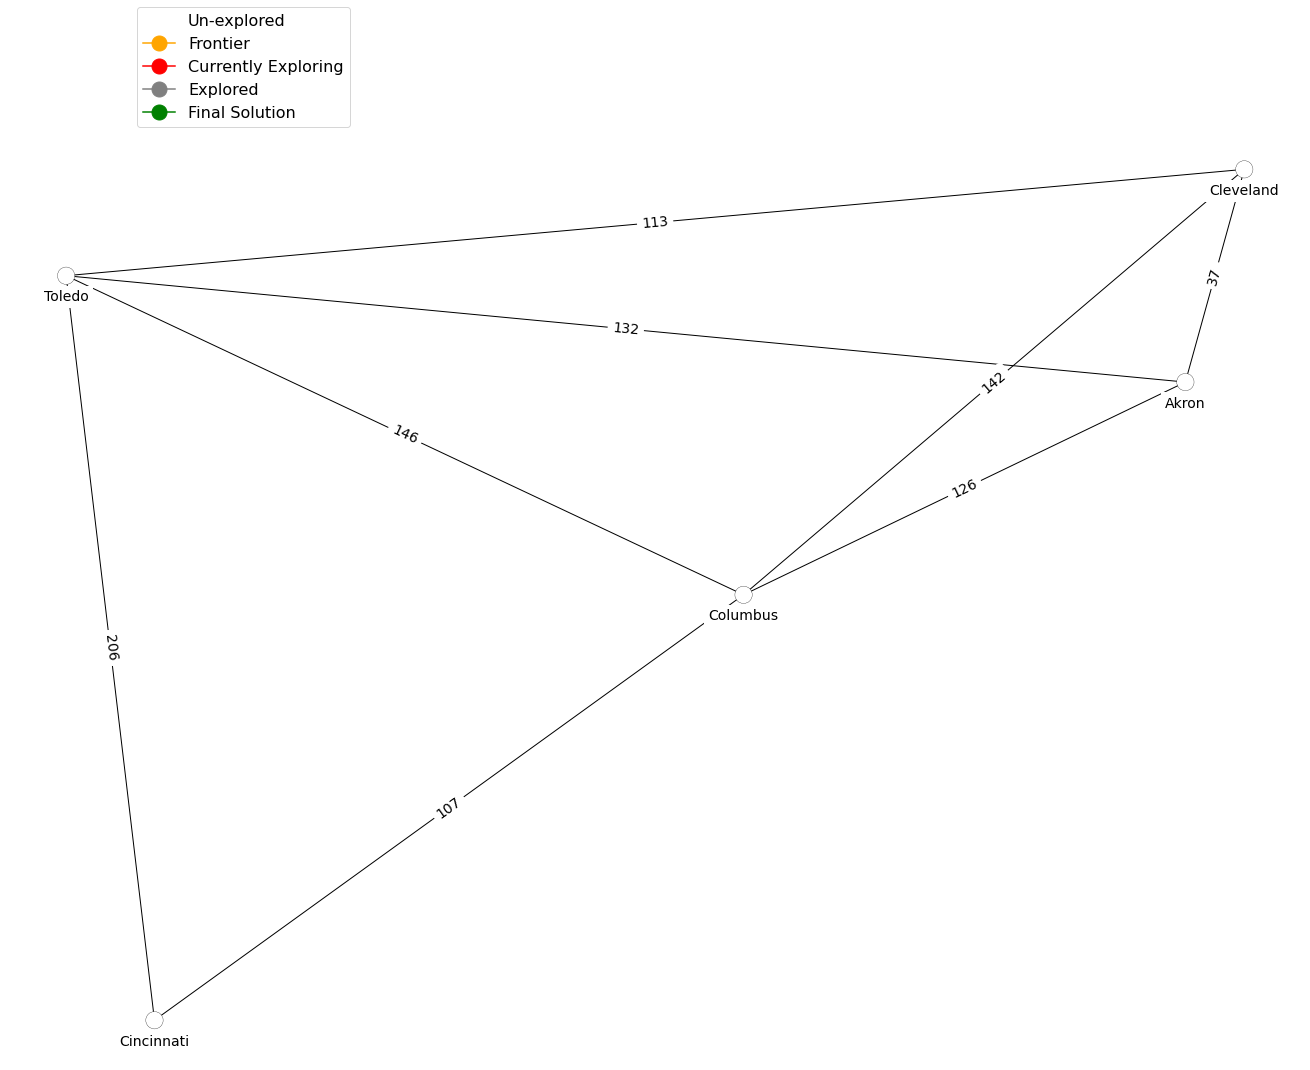

In [10]:
show_map(ohio_graph_data)

In [11]:
def tree_breadth_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    #Adding first node to the queue
    frontier = deque([Node(problem.initial_state)])
    
    node_colors[Node(problem.initial_state).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        #Popping first node of queue
        node = frontier.popleft()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def breadth_first_tree_search(problem):
    "Search the shallowest nodes in the search tree first."
    iterations, all_node_colors, node = tree_breadth_search_for_vis(problem)
    return(iterations, all_node_colors, node)

In [ ]:
all_node_colors = []
ohio_problem = GraphProblem('Cinncinati', 'Cleveland', ohio_map)
display_visual(ohio_graph_data, user_input=False, 
               algorithm=breadth_first_tree_search, 
               problem=ohio_problem)